# Experiments on wide-field dataset
- This python notebook contains the code to repeat all results using wide-field dataset from [1].


### Step 0: Import python modules
- The below given segments will import packages needed for this demo

In [1]:
from itertools import accumulate
import seaborn as sns
import pandas as pd

from  wide_field_api import mice, stimuli, get_stimuli_for_mice, get_meta_info, check_dataset
from classification_api import classifiers
from classification_api import plot_supervised_classification_result, plot_semi_supervised_classification_result
from classification_api import run_supervised_classification, run_semi_supervised_classification
from classification_api import run_subset_supervised_classification, run_subset_semi_supervised_classification
from analysis_api import plot_reponse_correlation, plot_tSNE

from tqdm.notebook import tqdm
from ipywidgets import IntProgress

### Step 1: Download and check the dataset
- This dataset has been made available through figshare
- Download the dataset from [here](https://figshare.com/s/ca910ddc194208e66e17) 
- The dataset consists of five zipfiles.
- The contents of M1.zip should be extracted and placed as  "\[root_of_this_repo\]/wide_field_imaging/dataset/M1/". Similarly for other zip files.
- The five zip files corresponds to responses collected from five different mice
- The below given code checks if the dataset is downloaded properly and gives an overview of the different responses available for each mouse

In [2]:
for mouse in mice:
    print(mouse.value, end =":\t")
    for stimuli in get_stimuli_for_mice(mouse):
        if not check_dataset(mouse,stimuli): 
            print("Dataset not found for "+mouse.value+"("+stimuli.value+
                  ") in wide_field_imaging/dataset/"+mouse.value+"/"+stimuli.value, flush=True)
        print(stimuli.value, end ="\t")
    print("\n")

M1:	Direction	Natural_Movies	Spatial_Frequency	Temporal_Frequency	

M2:	Natural_Movies	

M3:	Natural_Movies	

M4:	Natural_Movies	Resting_State	

M5:	Natural_Movies	Resting_State	



### Step 2: Train and test neuronal responses using supervised classifier (Table 3)
- Four different types of classifier have been implemented
- Step 1. Needs to be verfied before running this step.
- These results are given in Table 3 of the paper. The result may slightly vary from [1] due to averaging across random initialization. 

In [3]:
for mouse in tqdm(mice):
    for stimuli in get_stimuli_for_mice(mouse):
        acc = run_supervised_classification(mouse, stimuli, classifiers.GMM) #classifier.ANN - neural network classifier
        print('Accuracy of Classifying '+mouse.value+'('+stimuli.value+      #classifier.SVM - svm classifier
              ') data : '+str(round(acc,2)))                                 #classifier.Unimodal_Bayes - unimodal
                                                                             #                            Bayes classifier

Accuracy of Classifying M1(Direction) data : 94.17
Accuracy of Classifying M1(Natural_Movies) data : 96.87
Accuracy of Classifying M1(Spatial_Frequency) data : 95.69
Accuracy of Classifying M1(Temporal_Frequency) data : 90.31
Accuracy of Classifying M2(Natural_Movies) data : 97.82
Accuracy of Classifying M3(Natural_Movies) data : 97.09
Accuracy of Classifying M4(Natural_Movies) data : 97.56
Accuracy of Classifying M4(Resting_State) data : 96.33
Accuracy of Classifying M5(Natural_Movies) data : 98.23
Accuracy of Classifying M5(Resting_State) data : 96.33



### Step 3: Plot the boundraies predicted by the supervised classifier in Step 2 (Figs 2, 3 & 4)
- In this step the classification ( or misclassification) is shown by comparing the results obtained in Step 2 with the retintopic boundaries
- This step also prints confusion matrix
- See Section 2.1 and Figs 2, 3 & 4 in [1] for further details

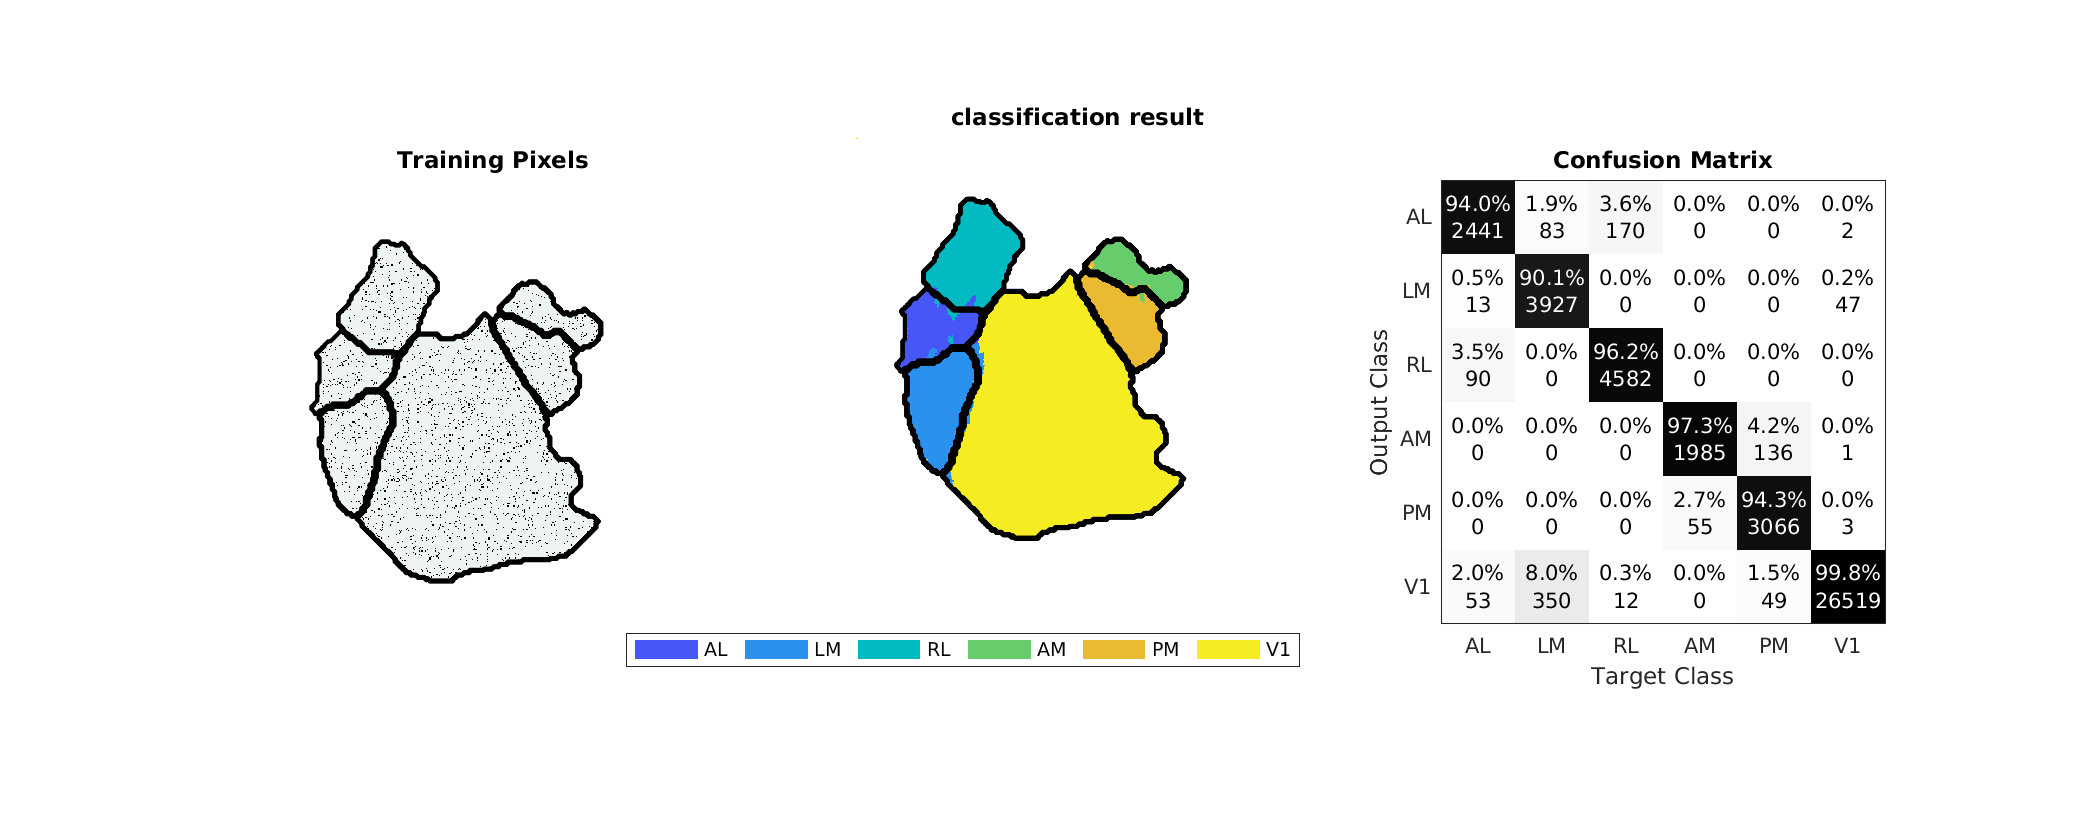

In [4]:
from IPython.display import Image, display

Image(filename=plot_supervised_classification_result(mouse.M4, stimuli.Natural_Movies, classifiers.GMM)) 

### Step 5: Perform semi-supervised classification (Table 5)
- In the step semi-supervised classifier is used to cluster the visual area responses
- See Section 2.2 in [1] for further details
- These results are given in Table 5 of the paper [1]. The result may slightly vary from [1] due to averaging across multiple random initialization.

In [6]:
for mouse in tqdm(mice):
    for stimuli in get_stimuli_for_mice(mouse):
        acc = run_semi_supervised_classification(mouse, stimuli)
        print('Results of Classifying '+mouse.value+'('+stimuli.value+') data using '+
              'semi-supervised approach: '+str(round(acc,2)))

Results of Classifying M1(Direction) data using semi-supervised approach: 57.7
Results of Classifying M1(Natural_Movies) data using semi-supervised approach: 60.57
Results of Classifying M1(Spatial_Frequency) data using semi-supervised approach: 57.41
Results of Classifying M1(Temporal_Frequency) data using semi-supervised approach: 62.64
Results of Classifying M2(Natural_Movies) data using semi-supervised approach: 73.37
Results of Classifying M3(Natural_Movies) data using semi-supervised approach: 72.7
Results of Classifying M4(Natural_Movies) data using semi-supervised approach: 72.1
Results of Classifying M4(Resting_State) data using semi-supervised approach: 72.07
Results of Classifying M5(Natural_Movies) data using semi-supervised approach: 80.48
Results of Classifying M5(Resting_State) data using semi-supervised approach: 78.63



### Step 6: Plot the boundraies predicted by the semi-supervised classifier in Step 5 (Figs 5 & 6)
- In this step the classification (or misclassification) is shown by comparing the semi-supervised result with the retintopic boundaries.
- See Section 2.2 and Figs 5 & 6 in [1] for further details

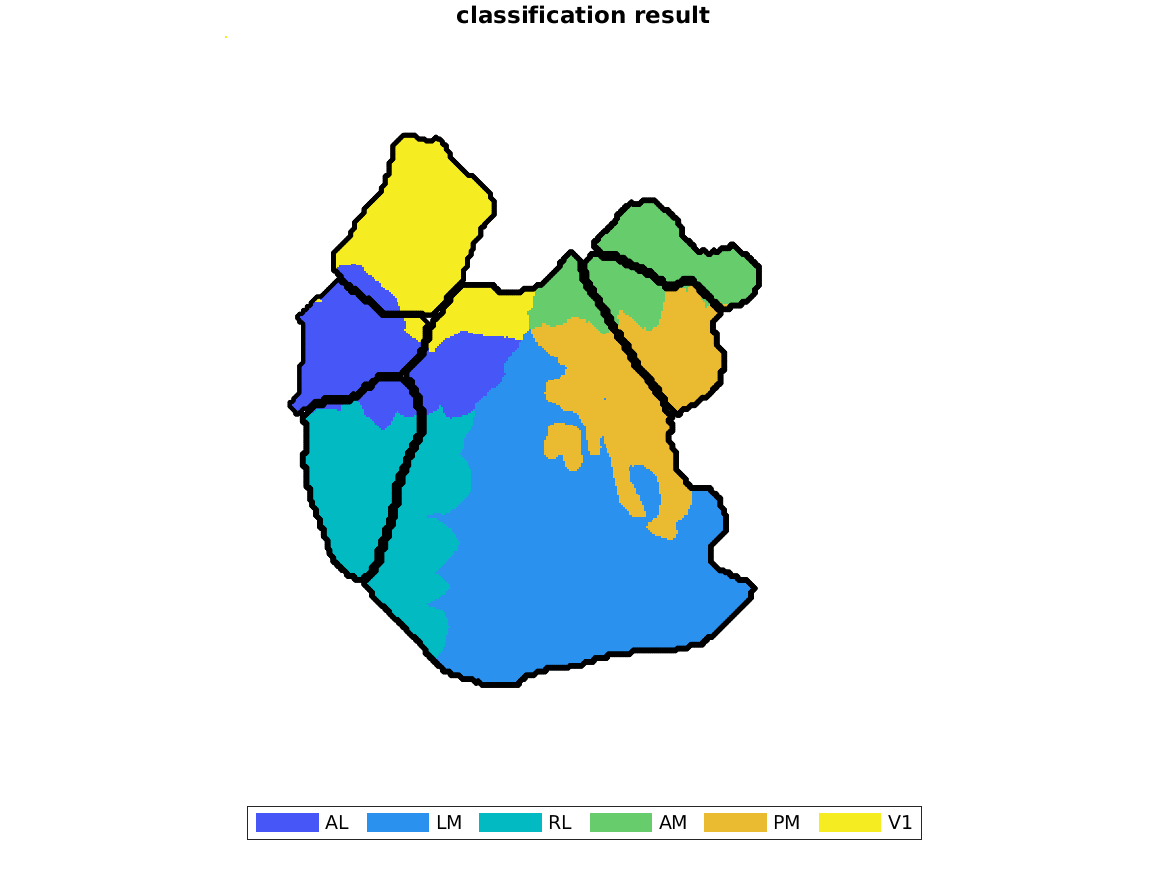

In [7]:
from IPython.display import Image, display

Image(filename=plot_semi_supervised_classification_result(mice.M4, stimuli.Natural_Movies),width=500) 

### Step 7: Compare resting state and  stimulus induced responses using supervised classifiers (Fig 7)¶
-See Section 2.3 of [1] for more details of below given experiment.

In [8]:
[stim, duration] = get_meta_info(mice.M4, stimuli.Natural_Movies)

df = pd.DataFrame(columns = ['Trial_Number', 'Accuracy', 'Duration', 'Stimuli'])  

progressve_duration = list(accumulate(duration))

for duration in tqdm(progressve_duration):
    for trial in range(5):
        acc = run_subset_supervised_classification(mice.M4, stimuli.Resting_State, classifiers.GMM, float(duration), False)
        df.loc[len(df)] = [trial, acc, duration, stimuli.Resting_State.value]
        
        acc = run_subset_supervised_classification(mice.M4, stimuli.Natural_Movies, classifiers.GMM, float(duration), True)
        df.loc[len(df)] = [trial, acc, duration, stimuli.Natural_Movies.value+"_Single_Trial"]

        acc = run_subset_supervised_classification(mice.M4, stimuli.Natural_Movies, classifiers.GMM, float(duration), False)
        df.loc[len(df)] = [trial, acc, duration, stimuli.Natural_Movies.value+"_Multi_Trial"]
print(df)


    Trial_Number   Accuracy  Duration                      Stimuli
0              0  83.560481       4.5                Resting_State
1              0  82.633535       4.5  Natural_Movies_Single_Trial
2              0  93.258994       4.5   Natural_Movies_Multi_Trial
3              1  83.292034       4.5                Resting_State
4              1  81.933737       4.5  Natural_Movies_Single_Trial
..           ...        ...       ...                          ...
175            3  97.636747      54.0  Natural_Movies_Single_Trial
176            3  97.941905      54.0   Natural_Movies_Multi_Trial
177            4  94.536986      54.0                Resting_State
178            4  97.531204      54.0  Natural_Movies_Single_Trial
179            4  97.528910      54.0   Natural_Movies_Multi_Trial

[180 rows x 4 columns]


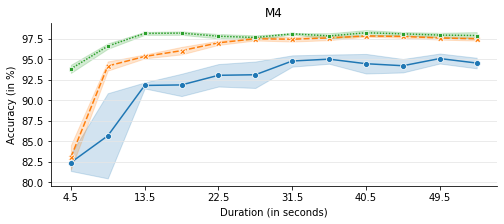

In [9]:
ax = sns.lineplot(x="Duration", y="Accuracy",
             hue="Stimuli",style="Stimuli",markers=True,ci="sd", legend=False,
             data=df)
sns.despine()
ax.set_title("M4")
ax.set_xlabel("Duration (in seconds)")
ax.set_ylabel("Accuracy (in %)")
ax.grid(axis='y', color='0.90')
x_t = [x*4.5 for x in range(1,13,2)]
ax.set_xticks(x_t);
#ax.set_aspect(0.5);
fig = ax.get_figure()
fig.set_size_inches(8, 3)

### Step 8: Compare resting state and  stimulus induced responses using semi-supervised classifiers (Fig 7)¶
-See Section 2.3 of [1] for more details of below given experiment.

In [ ]:
[stim, duration] = get_meta_info(mice.M4, stimuli.Natural_Movies)

df = pd.DataFrame(columns = ['Trial_Number', 'Accuracy', 'Duration', 'Stimuli'])  

progressve_duration = list(accumulate(duration))

for duration in tqdm(progressve_duration):
    for trial in range(3):
        acc = run_subset_semi_supervised_classification(mice.M4, stimuli.Resting_State, classifiers.GMM, float(duration), False)
        df.loc[len(df)] = [trial, acc, duration, stimuli.Resting_State.value]
        
        acc = run_subset_semi_supervised_classification(mice.M4, stimuli.Natural_Movies, classifiers.GMM, float(duration), True)
        df.loc[len(df)] = [trial, acc, duration, stimuli.Natural_Movies.value+"_Single_Trial"]

        acc = run_subset_semi_supervised_classification(mice.M4, stimuli.Natural_Movies, classifiers.GMM, float(duration), False)
        df.loc[len(df)] = [trial, acc, duration, stimuli.Natural_Movies.value+"_Multi_Trial"]
print(df)

In [ ]:
ax = sns.lineplot(x="Duration", y="Accuracy",
             hue="Stimuli",style="Stimuli",markers=True,ci="sd", legend=False,
             data=df)
sns.despine()
ax.set_title("M4")
ax.set_xlabel("Duration (in seconds)")
ax.set_ylabel("Accuracy (in %)")
ax.grid(axis='y', color='0.90')
x_t = [x*4.5 for x in range(1,13,2)]
ax.set_xticks(x_t);
#ax.set_aspect(0.5);
fig = ax.get_figure()
fig.set_size_inches(8, 3)

### Step 9: Compute correlations in reponses from different areas (Fig 8)
- see Section 3 of [1] for more details on the figure obtained below

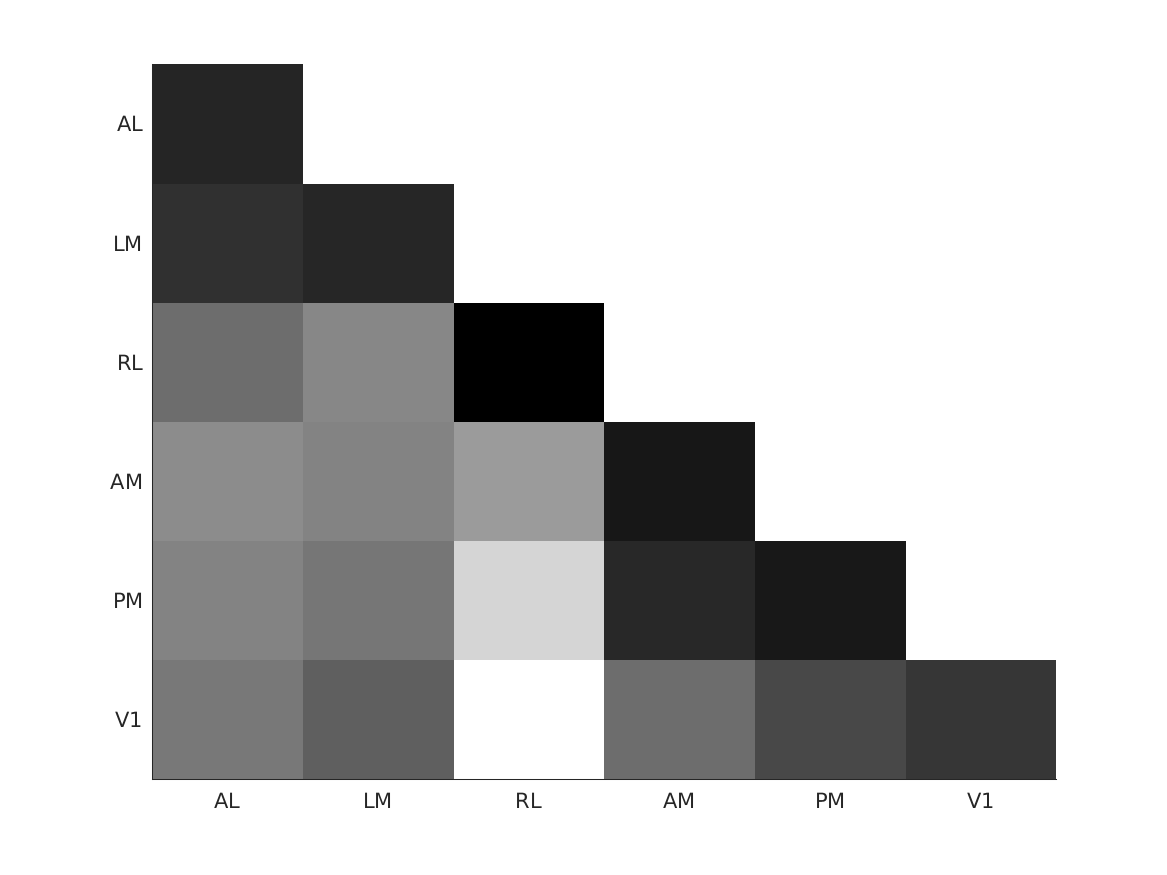

In [12]:
from IPython.display import Image, display

Image(filename=plot_reponse_correlation(mice.M4, stimuli.Natural_Movies), width=400) 

### Step 10: 2D representation of wide-field responses (Fig 9)
- see Section 3 or Fig 9 of [1] for more details on the figure obtained below.
- Note: embeddings on tSNE plots vary slightly based on random initialization 

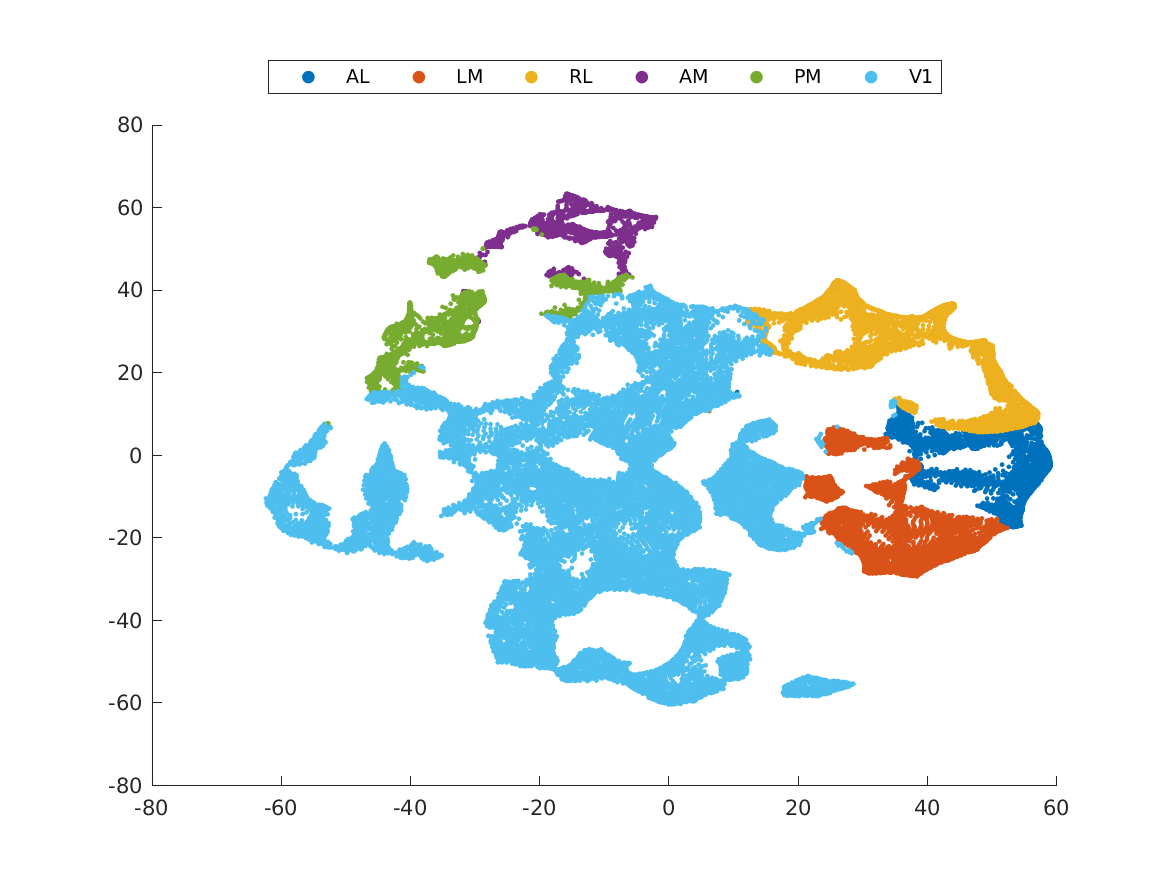

In [14]:
from IPython.display import Image, display

Image(filename=plot_tSNE(mice.M4, stimuli.Natural_Movies), width=600)

### References
[1] Mari Ganesh Kumar, Ming Hu, Aadhirai R, Mriganka Sur, and Hema A Murthy. “’Functional Parcellation of Mouse Visual Cortex Using Statistical Techniques Reveals Response-Dependent Clustering of Cortical Processing Areas”. In: PLOS Computational Biology (2020). Accepted For Publication